In [1]:
import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

# Quickstart to Parcels

## Reading in data from arbritrary NetCDF files

In [3]:
example_dataset_folder = "/Volumes/advector/_history_reanalysis_1y/hindcast/Global_Ocean_Models/nemo_hourly" 

In [4]:
filenames = {
    "U": f"{example_dataset_folder}/nemo_hourly_operational_u_2020-01*.nc",
    "V": f"{example_dataset_folder}/nemo_hourly_operational_v_2020-01*.nc",
}

variables = {"U": "uo", "V": "vo"}

dimensions = {"lon": "longitude", "lat": "latitude", "time": "time"}

In [ ]:
parcels.timer.root = parcels.timer.Timer("root")

In [ ]:
parcels.timer.fieldset = parcels.timer.Timer(
    "fieldset creation", parent=parcels.timer.root
)

fieldset = parcels.FieldSet.from_nemo(
    filenames, variables, dimensions, allow_time_extrapolation=False # avoids extrapolation of 1 day field over the run period 
) 

parcels.timer.fieldset.stop()

In [6]:
pset = parcels.ParticleSet.from_line(
    fieldset=fieldset,
    pclass=parcels.JITParticle,
    size=5,  # releasing 5 particles
    start=(28, -33),  # releasing on a line: the start longitude and latitude
    finish=(30, -33),  # releasing on a line: the end longitude and latitude
)

# Define a new particleclass with Variable 'age' with initial value 0.
AgeParticle = parcels.JITParticle.add_variable(parcels.Variable("age", initial=0))

pset = parcels.ParticleSet(
    fieldset=fieldset,  # the fields that the particleset uses
    pclass=AgeParticle,  # define the type of particle
    lon=29,  # release longitude
    lat=-33,  # release latitude
)



In [ ]:
output_file = pset.ParticleFile(
    name="NEMOParticles.zarr", outputdt=timedelta(hours=6)
)
pset.execute(
    parcels.AdvectionRK4,
    runtime=timedelta(days=1),
    dt=timedelta(minutes=60),
    output_file=output_file,
)

INFO: Output files are stored in NEMOParticles.zarr.
 42%|████▏     | 36000.0/86400.0 [07:38<09:42, 86.47it/s]

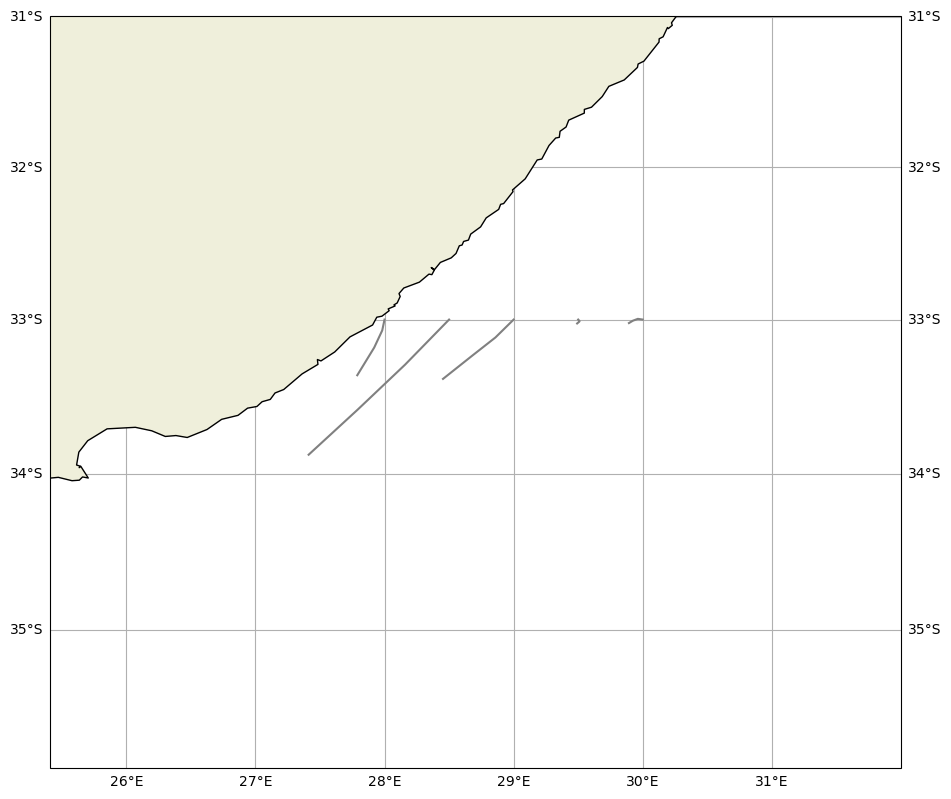

In [8]:
ds = xr.open_zarr("NEMOParticles.zarr")
ds.traj.plot(margin=2)
plt.show()

## Sampling a Field with Particles

https://archimer.ifremer.fr/doc/00157/26792/24888.pdf 

In [29]:
# this flow does not depend on time, we need to set allow_time_extrapolation=True when reading in the fieldset

example_dataset_folder = parcels.download_example_dataset("Peninsula_data")
fieldset = parcels.FieldSet.from_parcels(
    f"{example_dataset_folder}/peninsula",
    extra_fields={"P": "P"},
    allow_time_extrapolation=True,
)

In [30]:
SampleParticle = parcels.JITParticle.add_variable("p")

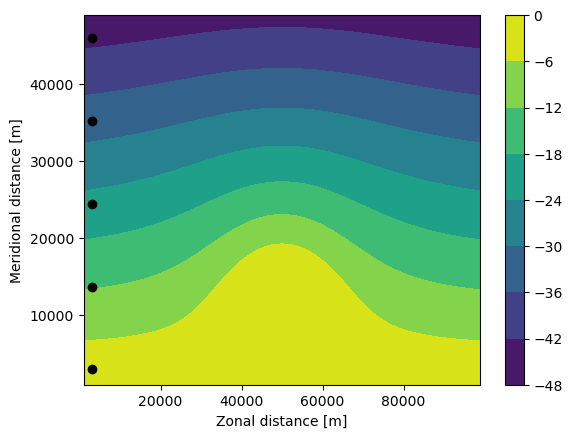

In [31]:
pset = parcels.ParticleSet.from_line(
    fieldset=fieldset,
    pclass=SampleParticle,
    start=(3000, 3000),
    finish=(3000, 46000),
    size=5,
    time=0,
)

plt.contourf(fieldset.P.grid.lon, fieldset.P.grid.lat, fieldset.P.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

In [34]:
def SampleP(particle, fieldset, time):
    """Custom function that samples fieldset.P at particle location"""
    particle.p = fieldset.P[time, particle.depth, particle.lat, particle.lon]

In [35]:
output_file = pset.ParticleFile(
    name="PeninsulaPressure.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    [parcels.AdvectionRK4, SampleP],  # list of kernels to be executed
    runtime=timedelta(hours=20),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in PeninsulaPressure.zarr.
100%|██████████| 72000.0/72000.0 [00:00<00:00, 77846.93it/s]


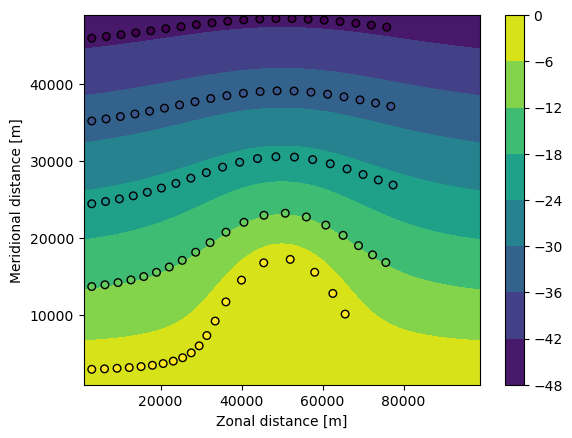

In [36]:
ds = xr.open_zarr("PeninsulaPressure.zarr")

plt.contourf(fieldset.P.grid.lon, fieldset.P.grid.lat, fieldset.P.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.scatter(ds.lon, ds.lat, c=ds.p, s=30, cmap="viridis", edgecolors="k")
plt.show()

## Calculating distance travelled

In [37]:
# to_write to write in output file

extra_vars = [
    parcels.Variable("distance", initial=0.0, dtype=np.float32),
    parcels.Variable(
        "prev_lon", dtype=np.float32, to_write=False, initial=attrgetter("lon")
    ),
    parcels.Variable(
        "prev_lat", dtype=np.float32, to_write=False, initial=attrgetter("lat")
    ),
]

DistParticle = parcels.JITParticle.add_variables(extra_vars)

In [38]:
def TotalDistance(particle, fieldset, time):
    """Calculate the distance in latitudinal direction
    (using 1.11e2 kilometer per degree latitude)"""
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    lon_dist = (
        (particle.lon - particle.prev_lon)
        * 1.11e2
        * math.cos(particle.lat * math.pi / 180)
    )
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    # Set the stored values for next iteration
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat

In [39]:
example_dataset_folder = parcels.download_example_dataset("GlobCurrent_example_data")
filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)
pset = parcels.ParticleSet.from_line(
    fieldset=fieldset, pclass=DistParticle, size=5, start=(28, -33), finish=(30, -33)
)

In [40]:
pset.execute(
    [parcels.AdvectionRK4, TotalDistance],  # list of kernels to be executed
    runtime=timedelta(days=6),
    dt=timedelta(minutes=5),
    output_file=pset.ParticleFile(
        name="GlobCurrentParticles_Dist.zarr", outputdt=timedelta(hours=1)
    ),
)

INFO: Output files are stored in GlobCurrentParticles_Dist.zarr.
100%|██████████| 518400.0/518400.0 [00:06<00:00, 74617.70it/s]


In [41]:
print([p.distance for p in pset])

[np.float32(13.197482), np.float32(640.92773), np.float32(543.45953), np.float32(183.60716), np.float32(172.74182)]
